## 页面版式分析并绘图的函数

In [1]:
import fitz  # PyMuPDF库，用于处理PDF文件
import matplotlib.patches as patches  # 用于在图像上绘制多边形
import matplotlib.pyplot as plt  # Matplotlib库，用于绘图
from PIL import Image  # 用于图像处理

def render_pdf_page(file_path, doc_list, page_number):
    """
    渲染指定PDF页面并绘制段落分类框。

    参数：
    - file_path: str，PDF文件路径。
    - doc_list: list，包含段落信息的文档列表，每个元素是一个字典，包含段落元数据。
    - page_number: int，要渲染的页面号（从1开始计数）。
    """
    # 打开PDF文件并加载指定页面
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    segments = [doc.metadata for doc in doc_list if doc.metadata.get("page_number") == page_number]

    # 将PDF页面渲染为位图图像
    pix = pdf_page.get_pixmap()
    pil_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    # 创建绘图环境
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(pil_image)

    # 定义类别颜色映射
    category_to_color = {"Title": "orchid", "Image": "forestgreen", "Table": "tomato"}
    categories = set()

    # 绘制段落标注框
    for segment in segments:
        points = segment["coordinates"]["points"]
        layout_width = segment["coordinates"]["layout_width"]
        layout_height = segment["coordinates"]["layout_height"]
        scaled_points = [
            (x * pix.width / layout_width, y * pix.height / layout_height) for x, y in points
        ]
        box_color = category_to_color.get(segment["category"], "deepskyblue")
        categories.add(segment["category"])
        rect = patches.Polygon(scaled_points, linewidth=1, edgecolor=box_color, facecolor="none")
        ax.add_patch(rect)

    # 添加图例
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]
    for category, color in category_to_color.items():
        if category in categories:
            legend_handles.append(patches.Patch(color=color, label=category))
    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
plt.show()

## 用Unstructured解析文档

In [2]:
file_path = '/home/huangj2/Documents/20250202_RAG_Book/data/山西文旅/云冈石窟-en.pdf'
from langchain_unstructured import UnstructuredLoader
loader = UnstructuredLoader(
    file_path=file_path,
    strategy="hi_res",
    partition_via_api=True, # 通过API调用Unstructured
    coordinates=True, # 返回元素位置坐标
)
docs = []
for doc in loader.lazy_load():
    docs.append(doc)

INFO: HTTP Request: GET https://api.unstructuredapp.io/general/docs "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"


In [3]:
import os
print(os.environ.get("UNSTRUCTURED_API_KEY", "Environment variable not found"))

i3Ns7H1t2kA6OtBlAEgJ3MKEIbGrO0


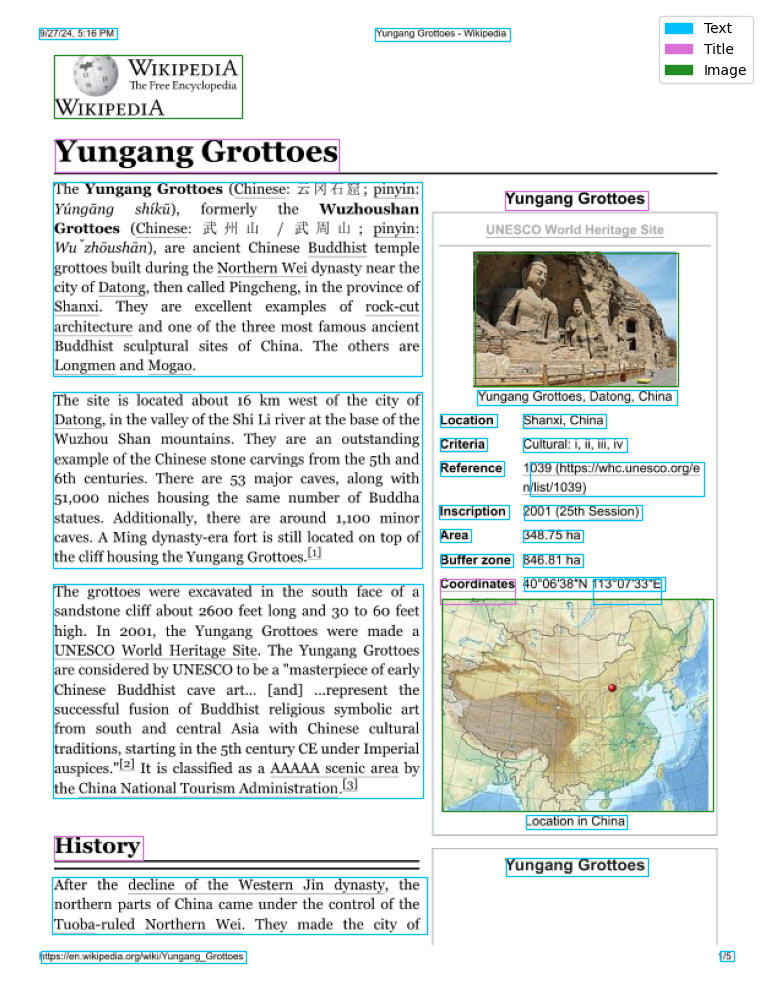

In [4]:
render_pdf_page(file_path,docs, 1)

In [30]:
# 仅筛选第一页的 Doc
page_number = 1
page_docs = [doc for doc in docs if doc.metadata.get("page_number") == page_number]

# 遍历并打印每个 Doc 的详细信息
for i, doc in enumerate(page_docs, 1):
    print(f"Doc {i}:")
    print(f"  内容: {doc.page_content}")
    print(f"  分类: {doc.metadata.get('category')}")
    print(f"  ID: {doc.metadata.get('element_id')}")
    print(f"  Parent ID: {doc.metadata.get('parent_id')}")
    print(f"  位置: {doc.metadata.get('position')}")
    print(f"  坐标: {doc.metadata.get('coordinates')}")
    print("="*50)


Doc 1:
  内容: 9/27/24, 5:16 PM
  分类: Header
  ID: 6659876cf076c9a9eb76a28d27ac56f1
  Parent ID: None
  位置: None
  坐标: {'points': [[65.17166900634766, 41.70912170410156], [65.17166900634766, 66.37327575683594], [240.922119140625, 66.37327575683594], [240.922119140625, 41.70912170410156]], 'system': 'PixelSpace', 'layout_width': 1700, 'layout_height': 2200}
Doc 2:
  内容: 4y WIKIPEDIA 1 The Free Encyclopedia WIKIPEDIA
  分类: Image
  ID: eac45dac5417f690e567f48af3edb950
  Parent ID: None
  位置: None
  坐标: {'points': [[98.4756851196289, 104.00216674804688], [98.4756851196289, 245.8692169189453], [525.8106689453125, 245.8692169189453], [525.8106689453125, 104.00216674804688]], 'system': 'PixelSpace', 'layout_width': 1700, 'layout_height': 2200}
Doc 3:
  内容: Yungang Grottoes
  分类: Title
  ID: 83492be26a7187c173f75f4a368bbdc6
  Parent ID: None
  位置: None
  坐标: {'points': [[101.27682495117188, 293.47064208984375], [101.27682495117188, 367.652587890625], [745.8444213867188, 367.652587890625], [745.8

In [7]:
# 解析文档并列出所有Title
titles = [doc.page_content for doc in docs if doc.metadata.get("category") == "Title"]

# 输出Title
print("本PDF中的 Title 包括：")
for i, title in enumerate(titles, 1):
    print(f"{i}. {title}")

本页面中的 Title 包括：
1. Yungang Grottoes
2. History
3. Yungang Grottoes
4. Crint
5. ancient
6. Deterioration and Conservation
7. Cave 6
8. Gallery
9. References
10. Further reading
11. External links


In [32]:
from IPython.core.display import display, HTML

# 仅筛选第一页的 Title
page_number = 1
title_dict = {}

# 收集 Title，并建立 parent_id -> Title 的映射
for doc in docs:
    if doc.metadata.get("category") == "Title" and doc.metadata.get("page_number") == page_number:
        title_id = doc.metadata.get("element_id")  # Title 的唯一 ID
        title_text = f"<h3 style='color: magenta;'>{doc.page_content}</h3>"
        title_dict[title_id] = {"title": title_text, "content": []}

# 关联 Title 和其对应的 Text
for doc in docs:
    if (doc.metadata.get("category") == "Text" or doc.metadata.get("category") == "NarrativeText") and doc.metadata.get("page_number") == page_number:
        parent_id = doc.metadata.get("parent_id")  # 这个 Text 归属于哪个 Title
        if parent_id in title_dict:
            title_dict[parent_id]["content"].append(doc.page_content)

# 组合输出 HTML
combined_html = ""
for title_data in title_dict.values():
    content_html = "<p>" + "</p><p>".join(title_data["content"]) + "</p>"
    combined_html += f"{title_data['title']}{content_html}<br>"

# 在 Jupyter Notebook 中显示格式化的输出
display(HTML(combined_html))

/tmp/ipykernel_828768/1071978929.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [11]:
import numpy as np

# 仅筛选第一页的 Image
page_number = 1
images = [doc for doc in docs if doc.metadata.get("category") == "Image" and doc.metadata.get("page_number") == page_number]

# 计算图片附近的文本
for i, image in enumerate(images, 1):
    image_box = np.array(image.metadata.get("coordinates", {}).get("points", []))

    # 如果没有坐标信息，则跳过
    if image_box.size == 0:
        continue

    # 计算图片的中心位置
    image_center_x = np.mean(image_box[:, 0])
    image_center_y = np.mean(image_box[:, 1])

    # 找到最近的文本
    nearby_texts = []
    for doc in docs:
        if doc.metadata.get("category") in ["Text", "Title"] and doc.metadata.get("page_number") == page_number:
            text_box = np.array(doc.metadata.get("coordinates", {}).get("points", []))
            if text_box.size == 0:
                continue

            # 计算文本的中心位置
            text_center_x = np.mean(text_box[:, 0])
            text_center_y = np.mean(text_box[:, 1])

            # 计算欧几里得距离
            distance = np.sqrt((text_center_x - image_center_x) ** 2 + (text_center_y - image_center_y) ** 2)

            # 设定合理的距离阈值，例如 300 以内的文本视为相邻
            if distance < 300:
                nearby_texts.append(doc.page_content)

    # 输出第一页图片附近的文本
    print(f"\n第一页图片 {i} 附近的文本：")
    print("\n".join(nearby_texts) if nearby_texts else "无相关文本")



第一页图片 1 附近的文本：
Yungang Grottoes

第一页图片 2 附近的文本：
Yungang Grottoes

第一页图片 3 附近的文本：
无相关文本
